## Loading data for a transient object

### Introduction

This notebook introduces how to load data for transient objects within this architecture, as well as the data transformations done as pre-processing before the Gaussian Process fitting

### Setup

Let's load all the classes and functions needed to demonstrate our data processing routines.

In [1]:
%load_ext autoreload
%autoreload 2
from caat import CAAT, DataCube, SN, SNCollection
import json
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

Configuration file not found:

    /Users/craigpellegrino/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


### 1. The Catalog of Archival Astronomical Transients

The backbone of the data in this architecture is the Catalog of Archival Astronomical Transients, or `CAAT`. A `CAAT` is an object that, at its core, contains a data structure of all the objects and their metadata in our sample. This is used throughout the processing and fitting routines to load objects by class, metadata such as an object's coordinate, redshift, and time and magnitude of peak brightness, among others.

For example, we can output an array of all objects in our sample of a given type and subtype:

In [2]:
caat = CAAT()
caat.get_sne_by_type("SNII", "SNIIP")

array(['SN2013fs', 'SN2009lq', 'SN2022fuc', 'SN2009N', 'SN2011hj',
       'SN2020dpw', 'SN2004dj', 'SN2021yyg', 'SN2010hq', 'SN2020aavm',
       'SN2022ewj', 'SN2010bj', 'SN2016X', 'SN2016L', 'SN2017ivu',
       'SN2020esm', 'SN1987A', 'SN2016B', 'SN2009ll', 'SN2009lm',
       'SN2018imf', 'SN2020uem', 'SN2018cxn', 'SN2021yja', 'SN2011gv',
       'SN2020sje', 'SN2011cj', 'SN2011ja'], dtype=object)

A newly initialized `CAAT` object will load a default catalog, unless one doesn't exist. It also contains methods to save and create new catalog files, in case any users need to keep separate catalogs for different use cases.

### 2. The SN object

Data for a single transient is loaded on init of a `SN` object. `SN` objects can be created by specifying either a name or by passing in a dictionary of data. If given a name, `SN` will utilize the default `CAAT` object to find the object's data and metadata. Let's see this in action:

In [3]:
sn = SN(name='SN2020ikq') # Instantiate SN class for single object
print(sn.info) # The metadata for this object

{'peak_mjd': 58970.46917415926, 'peak_mag': 18.3122667584888, 'peak_filt': 'g', 'searched': True, 'z': 0.037, 'ra': 204.020901072, 'dec': 28.9833628928}


The data is first loaded from any `.json` or `.txt` files in the repository, and is initialized as a dictionary:

In [4]:
sn.load_json_data()
sn.load_swift_data()
print(json.dumps(sn.data["c"][0], indent=4))

{
    "mag": 19.16712675541706,
    "err": 0.05870756092520456,
    "mjd": 58967.415468249994
}


We can also plot this data easily as either fluxes or magnitudes:

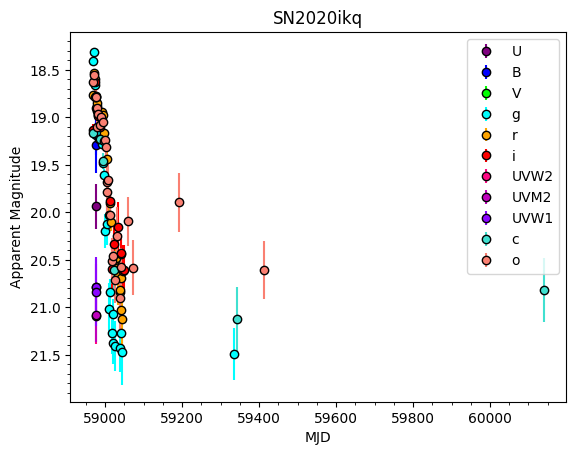

In [5]:
%matplotlib inline
sn.plot_data(plot_fluxes=False)

### 3. Processing the data

A number of steps must be done to go from raw photometry to data that is acceptable as input to the Gaussian Process fitting. 

To normalize the data, the time of data must first be shifted to the object's time of peak brightness, and its magnitude shifted to the magnitude at peak. This is done through two methods: `fit_for_max` (and its interactive version) and `shift_to_max`:

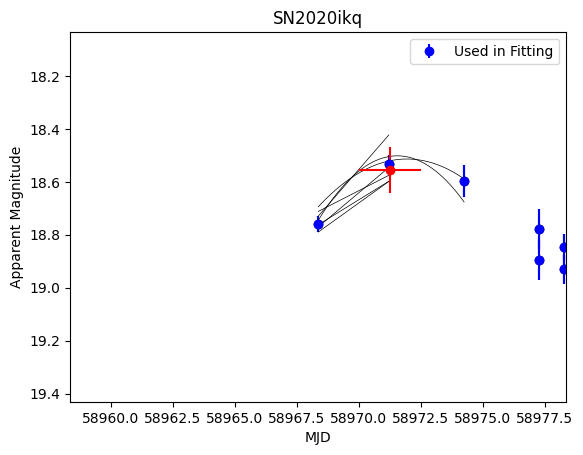

In [6]:
sn.fit_for_max(filt='r', plot=True)

The red data point is the computed point of max brightness. This is automatically saved to the `SN` object and used to shift the data:

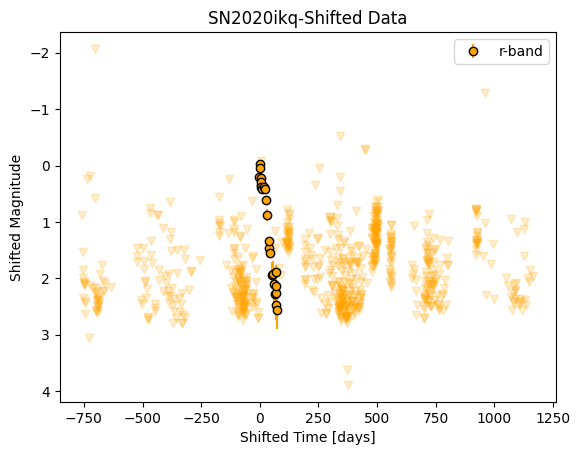

In [7]:
_ = sn.shift_to_max(filt='r', plot=True)

The data must also be log-transformed. This is crucial to the GP fitting because fitting in log space emphasizes variations at shorter wavelengths and epochs closer to explosion, when we expect the light curves and spectra to vary more rapidly. 

There's a simple method to log transform phases of `SN` photometry, given the shifted photometry calculated above as well as an arbitrary offset in the form of the `phase_start` parameter:

In [13]:
_ = sn.log_transform_time(
    phases=np.asarray([phot["mjd"] for phot in sn.shifted_data["r"]]),
    phase_start=30
)

Finally, we convert magnitudes to a rough equivalent of fluxes:

In [9]:
sn.convert_all_mags_to_fluxes()
print(sn.shifted_data)

{'r': [{'mjd': -2.8842913353219046, 'mag': 0.2023839965894645, 'err': 0.029562872186576432, 'nondetection': False, 'wle': 6491.62, 'flux': -0.08095359863578544, 'fluxerr': 0.029562872186576432}, {'mjd': -0.03737003527203342, 'mag': -0.022223271907350295, 'err': 0.03639480018186304, 'nondetection': False, 'wle': 6491.62, 'flux': 0.008889308762940473, 'fluxerr': 0.03639480018186304}, {'mjd': 2.9959748649635003, 'mag': 0.038506470614930066, 'err': 0.060322039402241207, 'nondetection': False, 'wle': 6491.62, 'flux': -0.015402588245972737, 'fluxerr': 0.060322039402241207}, {'mjd': 6.009632264882384, 'mag': 0.22094584363431125, 'err': 0.07652322537006513, 'nondetection': False, 'wle': 6491.62, 'flux': -0.08837833745372414, 'fluxerr': 0.07652322537006513}, {'mjd': 6.0101067648865865, 'mag': 0.3385910503870804, 'err': 0.07727413251686585, 'nondetection': False, 'wle': 6491.62, 'flux': -0.13543642015483215, 'fluxerr': 0.07727413251686585}, {'mjd': 7.03455126487097, 'mag': 0.2892842424316058, 'e

### 4. Iteratively warping the input photometry

Throughout this pre-processing, we have implicitly assumed that all the flux in a filter is "pinned" at the central wavelength of that filter. However, depending on the spectral energy distribution (SED) of the object at that phase, this assumption may not be correct. As a final pre-processing step, we will take our shifted photometry in flux space and iteratively warp the SED at each phase until the integrated SED across each filter matches the flux at a given wavelength. 

To do this, we will introduce a new class--the `DataCube`:

In [10]:
cube = DataCube(sn=sn)

On init, the `DataCube` loads the photometry for the given `SN` object, corrects for galactic extinction, shifts to maximum, and converts magnitudes to fluxes.

The `DataCube` class has a method, `construct_cube`, which takes the pre-processed photometry and constructs a `pandas` dataframe from it. 

Finally, the iterative warping takes place within the `measure_flux_in_filter` method. This takes as input a number of iterations `niter`, a `convergence_threshold`, and flags to plot and save the data. The algorithm steps through a phase grid, and at each phase gathers all photometry. An SED is fit across the observed photometry and each filter function is convolved with the SED to get a measured photometry. This measured photometry is compared to the observed photometry and the difference is used to warp the SED and a new central wavelength is chosen from the warped SED. This continues until each measured photometry is within the convergence threshold of the observed photometry, and the new central wavelength is recorded. The final warped photometry can then be saved to a `.csv` file, which is then read in by the `GP` class.

### 5. Plotting photometry for an entire class

Finally, there are several methods to plot all the photometry for a class of objects in our sample:

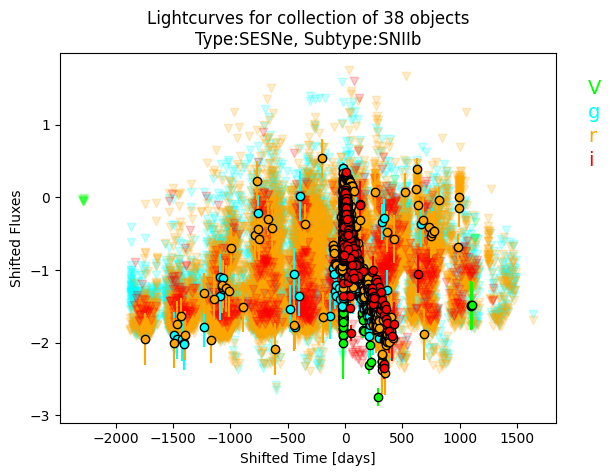

In [11]:
%matplotlib inline

IIb = SNCollection(sntype="SESNe",snsubtype="SNIIb") # All Type IIb SNe
# filts can take list of single or mulitple personally defined filters to plot
IIb.plot_all_lcs(filts=['V', 'g','r', 'i'], plot_fluxes=True)


The default is to plot all filters. 

We can also plot in log and magnitude space:

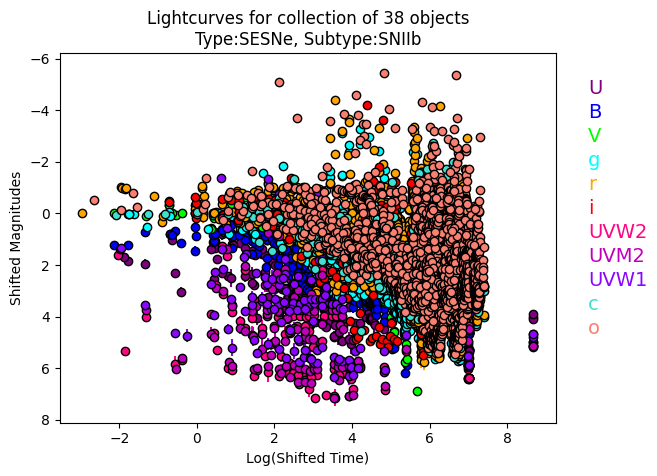

In [12]:
IIb.plot_all_lcs(log_transform=True, plot_fluxes=False)

### Next steps

These post processing steps ideally only need to be run once per object, after which the output is saved to the `CAAT` file or individual warped photometry `.csv` files. These data are then read at runtime when initializing and running the Gaussian Process regression. 